Humans are said to have unique gaits.<br>
Testing out the process developed for animals on humans.<br>
Using mediapipe to detect the keypoints of the human body.<br>

In [1]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os

In [20]:
model_path = os.path.join(os.getcwd(), 'models', 'pose_landmarker_heavy.task')

In [21]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
PoseLandmarkerResult = mp.tasks.vision.PoseLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a pose landmarker instance with the live stream mode:
def print_result(result: PoseLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    print('pose landmarker result: {}'.format(result))

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.LIVE_STREAM,
    result_callback=print_result)

# with PoseLandmarker.create_from_options(options) as landmarker:
  

Using Normalized x and y coordinates for the landmarks and the visibility above 0.7 as present.<br>
If the visibility is below 0.7, the landmark is considered absent.<br>
A future look might be to use a certain z coordinate if beyond a certain depth to be considered absent.<br>
Currently only store x and y coordinates.<br>

In [ ]:
import mediapipe as mp
import cv2
import pandas as pd
import datetime
import os
import json

# Load the labels from the JSON file
with open('labels.json') as f:
    labels = json.load(f)

# Define mp_drawing and mp_pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Create an instance of the Pose class
pose = mp.solutions.pose.Pose()

# Use OpenCV’s VideoCapture to start capturing from the webcam.
cap = cv2.VideoCapture(0)

# Create a window
cv2.namedWindow('MediaPipe Pose', cv2.WINDOW_NORMAL)

# Resize the window
cv2.resizeWindow('MediaPipe Pose', 800, 600)

frame_count = 0
landmarks_dict = dict()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

# Create a loop to read the latest frame from the camera using VideoCapture#read()
# and convert the frame to a format that can be processed by MediaPipe.
while cap.isOpened():
    success, image = cap.read()

    # count the framerate to write the video at the same framerate
    framerate = cap.get(cv2.CAP_PROP_FPS)
    # get the width and height of the frame
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # print(f'framerate: {framerate}, width: {width}, height: {height}')

    if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use 'break' instead of 'continue'.
        continue
    # print(frame_count)

    # Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Convert the landmarks to a list of dictionaries
    if results.pose_landmarks is not None:
        # Convert the landmarks to a list of dictionaries
        if results.pose_landmarks is not None:
            landmarks = {labels[str(i)]: {'x': landmark.x, 'y': landmark.y, 'z': landmark.z, 'visibility': 1 if landmark.visibility > 0.7 else 0} 
                         for i, landmark in enumerate(results.pose_landmarks.landmark)}
        else:
            landmarks = None
    else:
        landmarks = None

    landmarks_dict[f'landmarks_{frame_count}'] = landmarks

    # Draw pose landmarks on the image.
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.imshow('MediaPipe Pose', annotated_image)

    # Write the frame to the video
    out.write(annotated_image)

    if cv2.waitKey(5) & 0xFF == ord('q'):
        # Save the landmarks to a JSON file 
        if not os.path.exists('landmarks'):
            os.mkdir('landmarks')
        # write the landmarks dict to a JSON file with the current timestamp
        time_now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        with open(f'landmarks/landmarks_{time_now}.json', 'w') as f:
            json.dump(landmarks_dict, f, indent=4)
        
        if not os.path.exists('video'):
            os.mkdir('video')
        # Save the video with the current timestamp
        video_name = f'video/video_{time_now}.avi'
        out.release()
        os.rename('output.avi', video_name)
        break

    frame_count += 1

cap.release()
cv2.destroyAllWindows()


In [ ]:
kl = [i for i in mp_pose.PoseLandmark]
# dict(zip(kl,results.pose_landmarks.landmark))

In [ ]:
graph = {
    "nose": ["left eye (inner)", "right eye (inner)"],
    "left eye (inner)": ["nose", "left eye", "left eye (outer)"],
    "left eye": ["left eye (inner)", "left eye (outer)"],
    "left eye (outer)": ["left eye", "left eye (inner)"],
    "right eye (inner)": ["nose", "right eye", "right eye (outer)"],
    "right eye": ["right eye (inner)", "right eye (outer)"],
    "right eye (outer)": ["right eye", "right eye (inner)"],
    "left ear": [],
    "right ear": [],
    "mouth (left)": ["left shoulder", "left elbow", "left wrist"],
    "mouth (right)": ["right shoulder", "right elbow", "right wrist"],
    "left shoulder": ["mouth (left)", "left elbow"],
    "right shoulder": ["mouth (right)", "right elbow"],
    "left elbow": ["left shoulder", "left wrist"],
    "right elbow": ["right shoulder", "right wrist"],
    "left wrist": ["left elbow", "left pinky", "left thumb"],
    "right wrist": ["right elbow", "right pinky", "right thumb"],
    "left pinky": ["left wrist"],
    "right pinky": ["right wrist"],
    "left index": ["left wrist"],
    "right index": ["right wrist"],
    "left thumb": ["left wrist"],
    "right thumb": ["right wrist"],
    "left hip": ["left knee"],
    "right hip": ["right knee"],
    "left knee": ["left hip", "left ankle"],
    "right knee": ["right hip", "right ankle"],
    "left ankle": ["left knee", "left heel"],
    "right ankle": ["right knee", "right heel"],
    "left heel": ["left ankle"],
    "right heel": ["right ankle"],
    "left foot index": ["left heel"],
    "right foot index": ["right heel"]
}


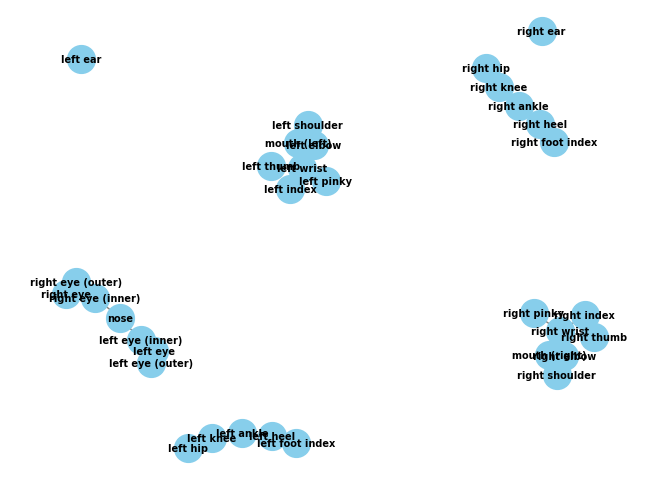

In [ ]:
import networkx as nx

G = nx.Graph(graph)

nx.draw(G, with_labels=True, font_weight='bold', node_size=400,
        node_color='skyblue', font_color='black', font_size=7, edge_color='grey')